# Convergence behaviours of different materials

In [10]:
using DFTK
using PyCall
using Plots
using LinearAlgebra
using KrylovKit

In [11]:
function plot_scf_convergence(basis, mixings=[KerkerMixing(α=0.7, kF=1.0),
                                              RestaMixing(εr=12, α=0.7, kF=1.0),
                                              SimpleMixing(α=0.7)]; kwargs...) 
    p = plot(yaxis=:log)
    for (i, mixing) in enumerate(mixings)
        energies = Float64[]
        function plot_callback(info)
            push!(energies, sum(values(info.energies)))
        end
        self_consistent_field(basis; tol=1e-8, mixing=mixings[i],
                              callback=plot_callback, maxiter=30, kwargs...)
            
        energies = abs.(energies[1:end-1] .- energies[end])
        plot!(p, energies, label=string(mixing))
    end
    p
end

plot_scf_convergence (generic function with 2 methods)

## 1D silicon (semiconductor)

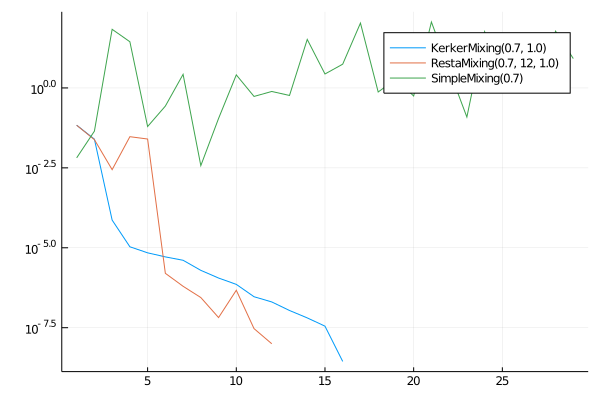

In [12]:
# Make a randomised supercell of Silicon of 30 units
ase_build = pyimport("ase.build")
silicon = ase_build.bulk("Si")
silicon = ase_build.make_supercell(silicon, Array(Diagonal([1, 1, 30])))
silicon.rattle()  # Add some random noise

# Get it all into the DFTK world
atoms = load_atoms(silicon)
atoms = [ElementPsp(el.symbol, psp=load_psp(el.symbol, functional="pbe")) => position
         for (el, position) in atoms]
lattice = load_lattice(silicon);

# Use a GGA model and setting all basis dimensions but one to 1 ("pseudo-1D")
Ecut = 50
model = model_LDA(lattice, atoms)
_, _, fft_z = determine_grid_size(model, Ecut)
basis_silicon = PlaneWaveBasis(model, Ecut; kgrid=[1, 1, 1], fft_size=[1, 1, fft_z])

plot_scf_convergence(basis_silicon)

## 1D aluminium (metal)

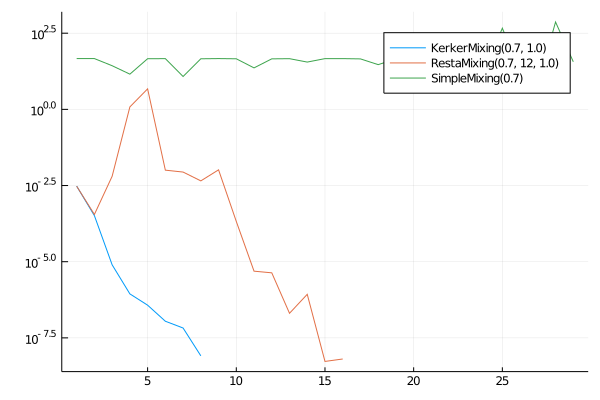

In [13]:
# Make a randomised supercell of aluminium of 30 units
ase_build = pyimport("ase.build")
aluminium = ase_build.bulk("Al")
aluminium = ase_build.make_supercell(aluminium, Array(Diagonal([1, 1, 30])))
aluminium.rattle()  # Add some random noise

# Get it all into the DFTK world
atoms = load_atoms(aluminium)
atoms = [ElementPsp(el.symbol, psp=load_psp(el.symbol, functional="pbe")) => position
         for (el, position) in atoms]
lattice = load_lattice(aluminium)

# Use a GGA model and setting all basis dimensions but one to 1 ("pseudo-1D")
Ecut = 50
model = model_LDA(lattice, atoms, smearing=Smearing.Gaussian(), temperature=0.001)
_, _, fft_z = determine_grid_size(model, Ecut)
basis_aluminium = PlaneWaveBasis(model, Ecut; kgrid=[1, 1, 1], fft_size=[1, 1, fft_z])

plot_scf_convergence(basis_aluminium, n_bands=50)

## 1D silica (quarz, insulator)

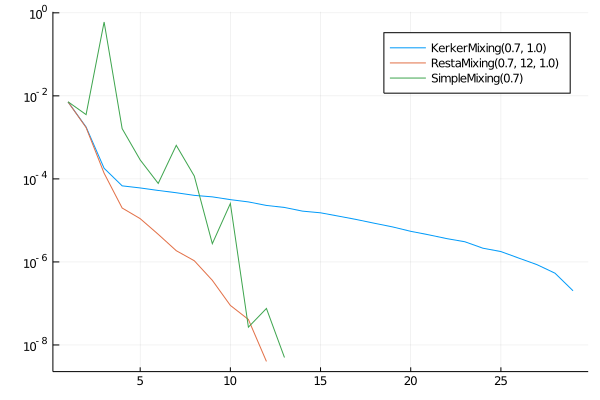

In [14]:
# Make a randomised supercell of silica of 20 units

# Lattice parameters for α-quartz from    
# https://www.materialsproject.org/materials/mp-549166/    
# All lengths in Ångström (used by ASE)    
a = b = 4.98530291    
c = 5.47852971    
α = β = 90    
γ = 120    

silicon = [  # Fractional coordinates    
    [0.000000  0.471138  0.833333],    
    [0.471138  0.000000  0.166666],    
    [0.528862  0.528862  0.500000],    
]    
oxygen = [  # Fractional coordinates    
    [0.148541  0.734505  0.046133],    
    [0.265495  0.414036  0.712800],    
    [0.585964  0.851459  0.379466],    
    [0.734505  0.148541  0.953867],    
    [0.414036  0.265495  0.287200],    
    [0.851459  0.585964  0.620534],    
]    
symbols = append!(fill("Si", 3), fill("O", 6))    
silica = pyimport("ase").Atoms(symbols=symbols, cell=[a, b, c, α, β, γ], pbc=true,    
                               scaled_positions=vcat(vcat(silicon, oxygen)...))    

silica = ase_build.make_supercell(silica, Array(Diagonal([1, 1, 20])))
silica.rattle()  # Add some random noise

# Get it all into the DFTK world
atoms = load_atoms(silica)
atoms = [ElementPsp(el.symbol, psp=load_psp(el.symbol, functional="pbe")) => position
         for (el, position) in atoms]
lattice = load_lattice(silica)

# Use a GGA model and setting all basis dimensions but one to 1 ("pseudo-1D")
Ecut = 400
model = model_LDA(lattice, atoms)
_, _, fft_z = determine_grid_size(model, Ecut)
basis_silica = PlaneWaveBasis(model, Ecut; kgrid=[1, 1, 1], fft_size=[1, 1, fft_z])

plot_scf_convergence(basis_silica)

## Spectral properties of the dielectric matrix

In [15]:
# Get a tightly converged SCF of aluminium
scfres = self_consistent_field(basis_aluminium; tol=1e-10, mixing=KerkerMixing(),
                               maxiter=30, n_bands=50);

n     Free energy       ρout-ρin   Eₙ₋₁-Eₙ    Diag
---   ---------------   --------   --------   ----
1     -65.229444102632   1.33e-01        NaN   8.0 
2     -65.232114146835   4.62e-02   2.67e-03   1.0 
3     -65.232288007666   1.12e-03   1.74e-04   2.0 
4     -65.232293370944   1.60e-04   5.36e-06   7.0 
5     -65.232293989270   7.58e-05   6.18e-07   4.0 
6     -65.232294245778   2.57e-05   2.57e-07   2.0 
7     -65.232294287578   6.98e-06   4.18e-08   4.0 
8     -65.232294291063   1.57e-06   3.49e-09   4.0 
9     -65.232294291273   4.04e-07   2.09e-10   3.0 
10    -65.232294291284   1.93e-07   1.16e-11   3.0 


In [16]:
# Function which applies ε = 1 - χ0 (vc + fxc)
function dielectric_operator(dρ)
    dρ = from_real(scfres.ham.basis, reshape(dρ, size(scfres.ρ.real)))
    dv = apply_kernel(scfres.ham.basis, dρ; ρ=scfres.ρ)
    χdv = apply_χ0(scfres.ham, scfres.ψ, scfres.εF, scfres.eigenvalues, dv)
    vec(dρ.real - χdv.real)    
end 

# Function which applies the Kerker preconditioner
function kerker_Pinv(dρ)    
    dρ = reshape(dρ, size(scfres.ρ.real))    
    dρ_dc = sum(dρ) / length(dρ)    
    dρ .-= dρ_dc    

    # Make dummy ρin and ρout to use mixing interface    
    ρin  = RealFourierArray(scfres.ham.basis)    
    ρout = from_real(scfres.ham.basis, dρ)    
    ρnext = DFTK.mix(KerkerMixing(), scfres.ham.basis, ρin, ρout; scfres...)    
    println()    

    vec(ρnext.real) .+ dρ_dc    
end

# A straightfoward Arnoldi eigensolver that diagonalizes the matrix at each step
# This is more efficient than Arpack when `f` is very expensive
function arnoldi(f, x0, howmany; tol=1e-4, maxiter=15)
    for (V, B, r, nr, b) in ArnoldiIterator(f, x0)
        # A * V = V * B + r * b'
        V = hcat(V...)
        AV = V*B + r*b'

        ew, ev = eigen(B, sortby=real)
        Vr = V*ev
        AVr = AV*ev
        R = AVr - Vr * Diagonal(ew)

        # Select `howmany` smallest and largest eigenpairs
        N = size(V, 2)
        inds = unique(append!(collect(1:min(N, howmany)), max(1, N-howmany):N))

        normr = [norm(r) for r in eachcol(R[:, inds])]
        println("#--- $N ---#")
        println("idcs      evals     residnorms")
        any(imag.(ew[inds]) .> 1e-5) && println("Warn: Suppressed imaginary part.")
        display(real.([inds ew[inds] normr]))
        println()
        if (N ≥ howmany && maximum(normr) < tol) || (N ≥ maxiter)
            return (indices=collect(inds), λ=ew[inds],
                    X=Vr[:, inds], AX=AVr[:, inds], residual_norms=normr)
        end
    end
end

arnoldi (generic function with 1 method)

In [17]:
arnoldi(dielectric_operator, randn(prod(size(scfres.ρ.real))), 5);

1×3 Array{Float64,2}:
 1.0  1.5728  7.47009

#--- 1 ---#
idcs      evals     residnorms



2×3 Array{Float64,2}:
 1.0    1.15338   2.09226
 2.0  128.848    35.6529

#--- 2 ---#
idcs      evals     residnorms



3×3 Array{Float64,2}:
 1.0    1.03032  0.486552
 2.0   33.3491   7.74542
 3.0  142.149    2.89441

#--- 3 ---#
idcs      evals     residnorms



4×3 Array{Float64,2}:
 1.0    1.00968  0.21125
 2.0   11.77     4.76719
 3.0   36.123    1.71089
 4.0  142.216    0.115457

#--- 4 ---#
idcs      evals     residnorms



5×3 Array{Float64,2}:
 1.0    1.00315  0.129458
 2.0    6.40856  3.45032
 3.0   15.9781   3.05555
 4.0   36.2432   0.320728
 5.0  142.216    0.00406329

#--- 5 ---#
idcs      evals     residnorms



6×3 Array{Float64,2}:
 1.0    1.00234   0.16885
 2.0    6.15128   4.80042
 3.0   15.7384    5.04752
 4.0   36.238     1.14047
 5.0   54.1323   64.5423
 6.0  142.216     0.00298378

#--- 6 ---#
idcs      evals     residnorms



7×3 Array{Float64,2}:
 1.0    0.9991   0.0912518
 2.0    3.11837  2.06666
 3.0    8.62142  1.7571
 4.0   16.5691   0.737061
 5.0   36.2447   0.0313837
 6.0  142.109    3.8273
 7.0  142.216    0.0858504

#--- 7 ---#
idcs      evals     residnorms



8×3 Array{Float64,2}:
 1.0    0.996506  0.053024
 2.0    1.96148   0.759868
 3.0    6.19144   1.11371
 4.0    9.65964   0.786757
 5.0   16.6233    0.117246
 6.0   36.2448    0.0016434
 7.0  142.214     0.0274248
 8.0  142.219     0.0341213

#--- 8 ---#
idcs      evals     residnorms



9×3 Array{Float64,2}:
 1.0    0.995387  0.122991
 2.0    1.79898   1.85196
 3.0    4.79353   6.5713
 4.0    7.00512   5.00477
 5.0    9.8242    1.74491
 6.0   16.6249    0.0940145
 7.0   36.2448    0.000464463
 8.0  142.214     0.00174539
 9.0  142.219     0.00217029

#--- 9 ---#
idcs      evals     residnorms



10×3 Array{Float64,2}:
  1.0    0.994818  0.0454719
  2.0    1.52733   0.565869
  3.0    3.10481   0.951178
  4.0    6.51831   0.386669
  5.0    9.75055   0.178014
  6.0   16.6245    0.0171345
  7.0   35.7386    4.13162
  8.0   36.2448    0.00364848
  9.0  142.214     6.92763e-5
 10.0  142.219     8.6144e-5

#--- 10 ---#
idcs      evals     residnorms



11×3 Array{Float64,2}:
  1.0    0.993268  0.0450443
  2.0    1.31868   0.450112
  3.0    2.41893   0.734913
  4.0    4.23276   1.00724
  5.0    6.56918   0.177588
  6.0    9.75525   0.0383847
  7.0   16.6245    0.00171834
  8.0   36.2448    0.0187569
  9.0   36.2488    0.171351
 10.0  142.214     6.77752e-7
 11.0  142.219     8.42741e-7

#--- 11 ---#
idcs      evals     residnorms



11×3 Array{Float64,2}:
  1.0    0.992754  0.0660606
  2.0    1.27486   0.629035
  3.0    2.27442   1.14827
  4.0    3.87616   1.95468
  5.0    6.49099   2.35088
  7.0    9.7558    0.0711846
  8.0   16.6245    0.000995457
  9.0   36.2448    0.00259056
 10.0   36.2506    0.0337957
 11.0  142.214     2.94983e-8
 12.0  142.219     3.66779e-8

#--- 12 ---#
idcs      evals     residnorms



11×3 Array{Float64,2}:
  1.0    0.991323  0.0444052
  2.0    1.16762   0.310158
  3.0    1.90906   0.527626
  4.0    2.98068   0.614129
  5.0    4.65959   0.534103
  8.0   16.4082    1.71499
  9.0   16.6245    0.00682332
 10.0   36.2448    0.000235196
 11.0   36.2505    0.00304632
 12.0  142.214     4.56951e-10
 13.0  142.219     5.68147e-10

#--- 13 ---#
idcs      evals     residnorms



11×3 Array{Float64,2}:
  1.0    0.9872   0.0592522
  2.0    1.06871  0.208421
  3.0    1.63549  0.34786
  4.0    2.4726   0.442052
  5.0    3.47677  0.485033
  9.0   16.6224   0.0978406
 10.0   16.6247   0.0392618
 11.0   36.2448   5.80381e-6
 12.0   36.2505   7.52773e-5
 13.0  142.214    2.69098e-12
 14.0  142.219    3.34147e-12

#--- 14 ---#
idcs      evals     residnorms



11×3 Array{Float64,2}:
  1.0    0.981057  0.0905498
  2.0    1.03078   0.170869
  3.0    1.48674   0.366289
  4.0    2.10548   0.552599
  5.0    2.824     0.543269
 10.0   16.6228    0.0063774
 11.0   16.6249    0.00333501
 12.0   36.2448    1.70474e-7
 13.0   36.2505    2.21071e-6
 14.0  142.214     1.36603e-13
 15.0  142.219     1.50235e-13

#--- 15 ---#
idcs      evals     residnorms



In [18]:
arnoldi(kerker_Pinv ∘ dielectric_operator, randn(prod(size(scfres.ρ.real))), 5);

1×3 Array{Float64,2}:
 1.0  0.758589  0.631632


#--- 1 ---#
idcs      evals     residnorms



2×3 Array{Float64,2}:
 1.0  0.284204  0.0365891
 2.0  0.779874  0.0292732


#--- 2 ---#
idcs      evals     residnorms



3×3 Array{Float64,2}:
 1.0  0.414585  0.0089797
 2.0  0.611332  0.0210639
 3.0  0.789024  0.0276824


#--- 3 ---#
idcs      evals     residnorms



4×3 Array{Float64,2}:
 1.0  0.407454  0.00321771
 2.0  0.598873  0.0147694
 3.0  0.781761  0.0382337
 4.0  0.863092  0.0929375


#--- 4 ---#
idcs      evals     residnorms


#--- 5 ---#
idcs      evals     residnorms
Warn: Suppressed imaginary part.

5×3 Array{Float64,2}:
 1.0  0.396404  0.00201847
 2.0  0.632036  0.0523481
 3.0  0.632036  0.0523481
 4.0  0.787399  0.0345537
 5.0  0.957882  0.11721

6×3 Array{Float64,2}:
 1.0  0.393087  0.00185079
 2.0  0.450823  0.0152574
 3.0  0.626388  0.00792091
 4.0  0.734098  0.0227058
 5.0  0.794568  0.0160775
 6.0  0.998542  0.023496


#--- 6 ---#
idcs      evals     residnorms



7×3 Array{Float64,2}:
 1.0  0.401349  0.00270887
 2.0  0.419915  0.0150664
 3.0  0.614437  0.0253439
 4.0  0.614437  0.0253439
 5.0  0.729072  0.0249035
 6.0  0.795537  0.00934214
 7.0  0.999831  0.0071846


#--- 7 ---#
idcs      evals     residnorms
Warn: Suppressed imaginary part.



8×3 Array{Float64,2}:
 1.0  0.395772  0.00144798
 2.0  0.417474  0.0110019
 3.0  0.513815  0.0348744
 4.0  0.668502  0.0205239
 5.0  0.668502  0.0205239
 6.0  0.754448  0.0370698
 7.0  0.796568  0.00953562
 8.0  0.999989  0.00199343


#--- 8 ---#
idcs      evals     residnorms
Warn: Suppressed imaginary part.



9×3 Array{Float64,2}:
 1.0  0.397932  0.0017126
 2.0  0.408331  0.0172826
 3.0  0.478022  0.0468186
 4.0  0.58183   0.0628191
 5.0  0.648623  0.00810926
 6.0  0.707178  0.0174398
 7.0  0.768643  0.0269435
 8.0  0.797261  0.00653473
 9.0  0.999999  0.000447458


#--- 9 ---#
idcs      evals     residnorms



10×3 Array{Float64,2}:
  1.0  0.397631  0.00150786
  2.0  0.40622   0.0132267
  3.0  0.458673  0.0408177
  4.0  0.538213  0.0563537
  5.0  0.642756  0.0323486
  6.0  0.659344  0.0565572
  7.0  0.710936  0.0212347
  8.0  0.773706  0.0195907
  9.0  0.797556  0.00480865
 10.0  1.0       0.00012468


#--- 10 ---#
idcs      evals     residnorms



11×3 Array{Float64,2}:
  1.0  0.39586   0.000855639
  2.0  0.40887   0.00428216
  3.0  0.4416    0.01489
  4.0  0.506961  0.0240363
  5.0  0.585087  0.0202458
  6.0  0.671268  0.0129702
  7.0  0.671268  0.0129702
  8.0  0.737794  0.0239364
  9.0  0.778123  0.0195695
 10.0  0.797784  0.00454085
 11.0  1.0       3.44855e-5


#--- 11 ---#
idcs      evals     residnorms
Warn: Suppressed imaginary part.



11×3 Array{Float64,2}:
  1.0  0.400623  0.00189059
  2.0  0.400623  0.00189059
  3.0  0.432778  0.0145524
  4.0  0.48774   0.0244097
  5.0  0.553813  0.0281903
  7.0  0.664555  0.0115209
  8.0  0.69953   0.0134246
  9.0  0.754899  0.0267883
 10.0  0.782931  0.018625
 11.0  0.798004  0.00413217
 12.0  1.0       8.2588e-6


#--- 12 ---#
idcs      evals     residnorms
Warn: Suppressed imaginary part.



11×3 Array{Float64,2}:
  1.0  0.397972  0.000977191
  2.0  0.402702  0.00667891
  3.0  0.428145  0.0223857
  4.0  0.471546  0.040175
  5.0  0.52328   0.051858
  8.0  0.662199  0.0378875
  9.0  0.710835  0.0103684
 10.0  0.760356  0.0187928
 11.0  0.785335  0.012968
 12.0  0.798119  0.00288407
 13.0  1.0       2.09112e-6


#--- 13 ---#
idcs      evals     residnorms



11×3 Array{Float64,2}:
  1.0  0.396745  0.000494971
  2.0  0.404932  0.00292887
  3.0  0.421827  0.00977151
  4.0  0.457116  0.0186165
  5.0  0.503663  0.0222416
  9.0  0.684858  0.0178186
 10.0  0.728954  0.021501
 11.0  0.765025  0.0225075
 12.0  0.787325  0.0147591
 13.0  0.798213  0.00324128
 14.0  1.0       6.27231e-7


#--- 14 ---#
idcs      evals     residnorms



11×3 Array{Float64,2}:
  1.0  0.399819  0.0012439
  2.0  0.399819  0.0012439
  3.0  0.417672  0.00759101
  4.0  0.445146  0.0151551
  5.0  0.486455  0.0209315
 10.0  0.701568  0.00765432
 11.0  0.744532  0.0214297
 12.0  0.770277  0.0177874
 13.0  0.789234  0.0113951
 14.0  0.798301  0.0025158
 15.0  1.0       1.45028e-7


#--- 15 ---#
idcs      evals     residnorms
Warn: Suppressed imaginary part.

